In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
from ParticlePlotFunctions import *
import matplotlib.animation as animation
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load bathymetry and land mask

latdim = np.arange(1000,2001)
londim = np.arange(2000,3001)
bathy_file = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/bathymetry_ORCA12_V3.3.nc'
dfile = Dataset(bathy_file)
bathy = dfile.variables['Bathymetry'][latdim,londim]
landmask = dfile.variables['mask'][latdim,londim]
lat = dfile.variables['nav_lat'][latdim,londim]
lon = dfile.variables['nav_lon'][latdim,londim]
bathy = np.where(bathy<1, nan, bathy)

In [3]:
#load particle data

namefile = '../../data/galapagosparticles_bwd_nemo_2008.nc'
Traj = ReadTrajectories(namefile)

In [13]:
print(Traj['time'][0:10,0])

['2008-12-28T12:00:00.000000000' '2008-12-28T12:00:00.000000000'
 '2008-12-28T12:00:00.000000000' '2008-12-28T12:00:00.000000000'
 '2008-12-28T12:00:00.000000000' '2008-12-28T12:00:00.000000000'
 '2008-12-28T12:00:00.000000000' '2008-12-28T12:00:00.000000000'
 '2008-12-28T12:00:00.000000000' '2008-12-28T12:00:00.000000000']


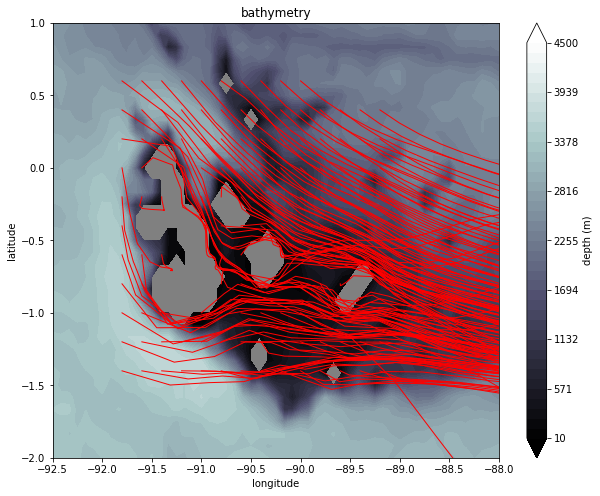

In [18]:
#quick check output

plat = Traj['lat'][0:150,0:200]
plon = Traj['lon'][0:150,0:200]
map_extent = [-92.5,-88,-2,1]
figsize=(10,8)
PlotBathyTraj(plon,plat,lon,lat,bathy,figsize,map_extent)
plt.savefig('../../results/figures/NEMO_resolution_parcels.pdf')

In [9]:
# Make histogram, number of particles per gridbox, no double counting

plat = Traj['lat'][:]
plon = Traj['lon'][:]

bins = [np.arange(-97,-74, 1), np.arange(-10, 11, 1)]
pmap = np.zeros([len(bins[0])-1,len(bins[1])-1], dtype=float)

for particle in range (len(plon)):
    plonn = plon[particle,:]
    platt = plat[particle,:]
    H, xe, ye = np.histogram2d(plonn[~isnan(plonn)],platt[~np.isnan(platt)], bins=bins)
    H[H > 0]=1
    pmap += H    

pmap=pmap/len(plon)

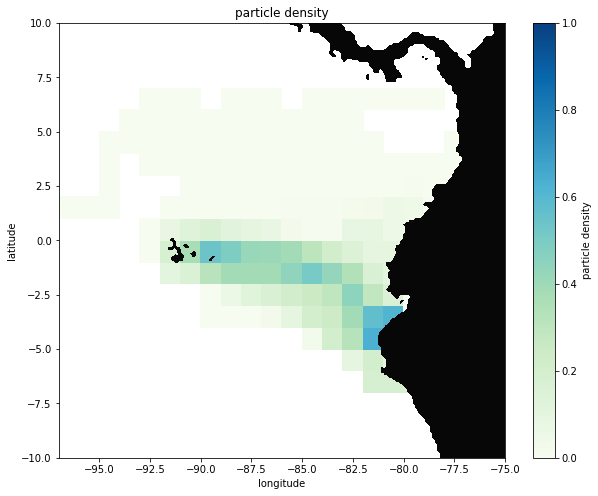

In [17]:
# Make plot with histogram made above and mask land
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)

vmax = 1
pmap[pmap==0]=nan
fig1 = ax.pcolor(bins[0][:-1],bins[1][:-1],pmap.T,           
                   cmap='GnBu',
                   vmin=0,
                   vmax=vmax)    
ax.set_title('particle density')          
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
cbar = plt.colorbar(fig1, ax=ax)
cbar.ax.set_ylabel('particle density')

landmask=landmask*1.0
landmask[landmask==1]=nan
levels = np.linspace(0, 1, 20)
fig2 = ax.contourf(lon, lat, landmask, cmap='Greys_r', levels=levels)
ax.set_xlim(bins[0][0],bins[0][-1])
ax.set_ylim(bins[1][0],bins[1][-1])
plt.savefig('../../results/figures/NEMO_parcelsdensity_dec2008.pdf')

In [ ]:
# Make a movie (works for both forward and backward)

map_extent = [-95,-75,-5,5]
pylab.rcParams['figure.figsize'] = (10, 5)
Zmin = 10
Zmax = 4500

plat = Traj['lat'][0:300,0:200]
plon = Traj['lon'][0:300,0:200]
ptime= Traj['time'][0:300,0:200]
plottimes = np.arange(np.min(ptime), np.max(ptime), dtype='datetime64[5D]')

# where is particle coming from
pdirection = np.zeros([plat.shape[0],3], dtype=int) #from where is particle coming
pdirection[:] = [0,1,0]
for p in range(plat.shape[0]):                      
    if np.any(plat[p,:] > 4.5) and not np.any(plat[p,:] < -4.5):          
        pdirection[p,:] = [0,0,1]
    if np.any(plat[p,:] < -4.5) and not np.any(plat[p,:] > 4.5):
        pdirection[p,:] = [1,0,0]
    if np.any(plat[p,:] < -4.5) and np.any(plat[p,:] > 4.5):
        latmax = np.where(plat[p,:] > 4.5)[0][0]    
        latmin = np.where(plat[p,:] < -4.5)[0][0]
        if latmax < latmin:
            pdirection[p,:] = [0,0,1]
        else:
            pdirection[p,:] = [1,0,0]

fig, ax = plt.subplots(1,1)

levels = np.linspace(Zmin, Zmax, 41)
fig1 = ax.contourf(lon,lat,bathy,       
                      levels = levels,    
                      cmap='bone',       
                      extend='both',      
                      origin='lower')              
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])
ax.set_facecolor('gray')
cbar = plt.colorbar(fig1, ax=ax)
cbar.ax.set_ylabel('depth (m)')

t=0
b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
scat = ax.scatter(plon[b], plat[b], s=3, c=pdirection[b[0],:])
ttl = ax.set_title('Particle location on ' + str(plottimes[0]))
frames = np.arange(0, len(plottimes)-1)

def animate(t):
    b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
    scat.set_offsets(np.vstack((plon[b], plat[b])).transpose())
    particle_color = pdirection[b[0],:]
    scat.set_color(particle_color)
    ttl.set_text('Particle location on ' + str(plottimes[t]))
    return scat,

ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
anim
anim.save('../../results/figures/galapagosparticles_south_vs_north.gif', writer='imagemagick', fps=10)